Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
###### Import libraries and mount google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

Here are the steps to load data into google drive:
1. Unzip the zip file.
2. Upload the unzipped data with proper folder structure to google drive.
3. Train data should be available at "/content/drive/MyDrive/CNN_Assignment/Train" and test data should be available at "/content/drive/MyDrive/CNN_Assignment/Test"

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_Assignment/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_Assignment/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


There are a total of 2249 train images and 118 test images

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Using seed=123 while creating dataset.
dataset = keras.utils.image_dataset_from_directory(data_dir_train,
                                         labels="inferred",
                                         batch_size=batch_size,
                                         image_size=(img_height, img_width),
                                         seed=123,
                                         validation_split=0.2,
                                         subset='both')
train_ds = dataset[0]
val_ds = dataset[1]

Found 2249 files belonging to 9 classes.
Using 1800 files for training.
Using 449 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
Visualizing one instance of all the nine classes present in the dataset.

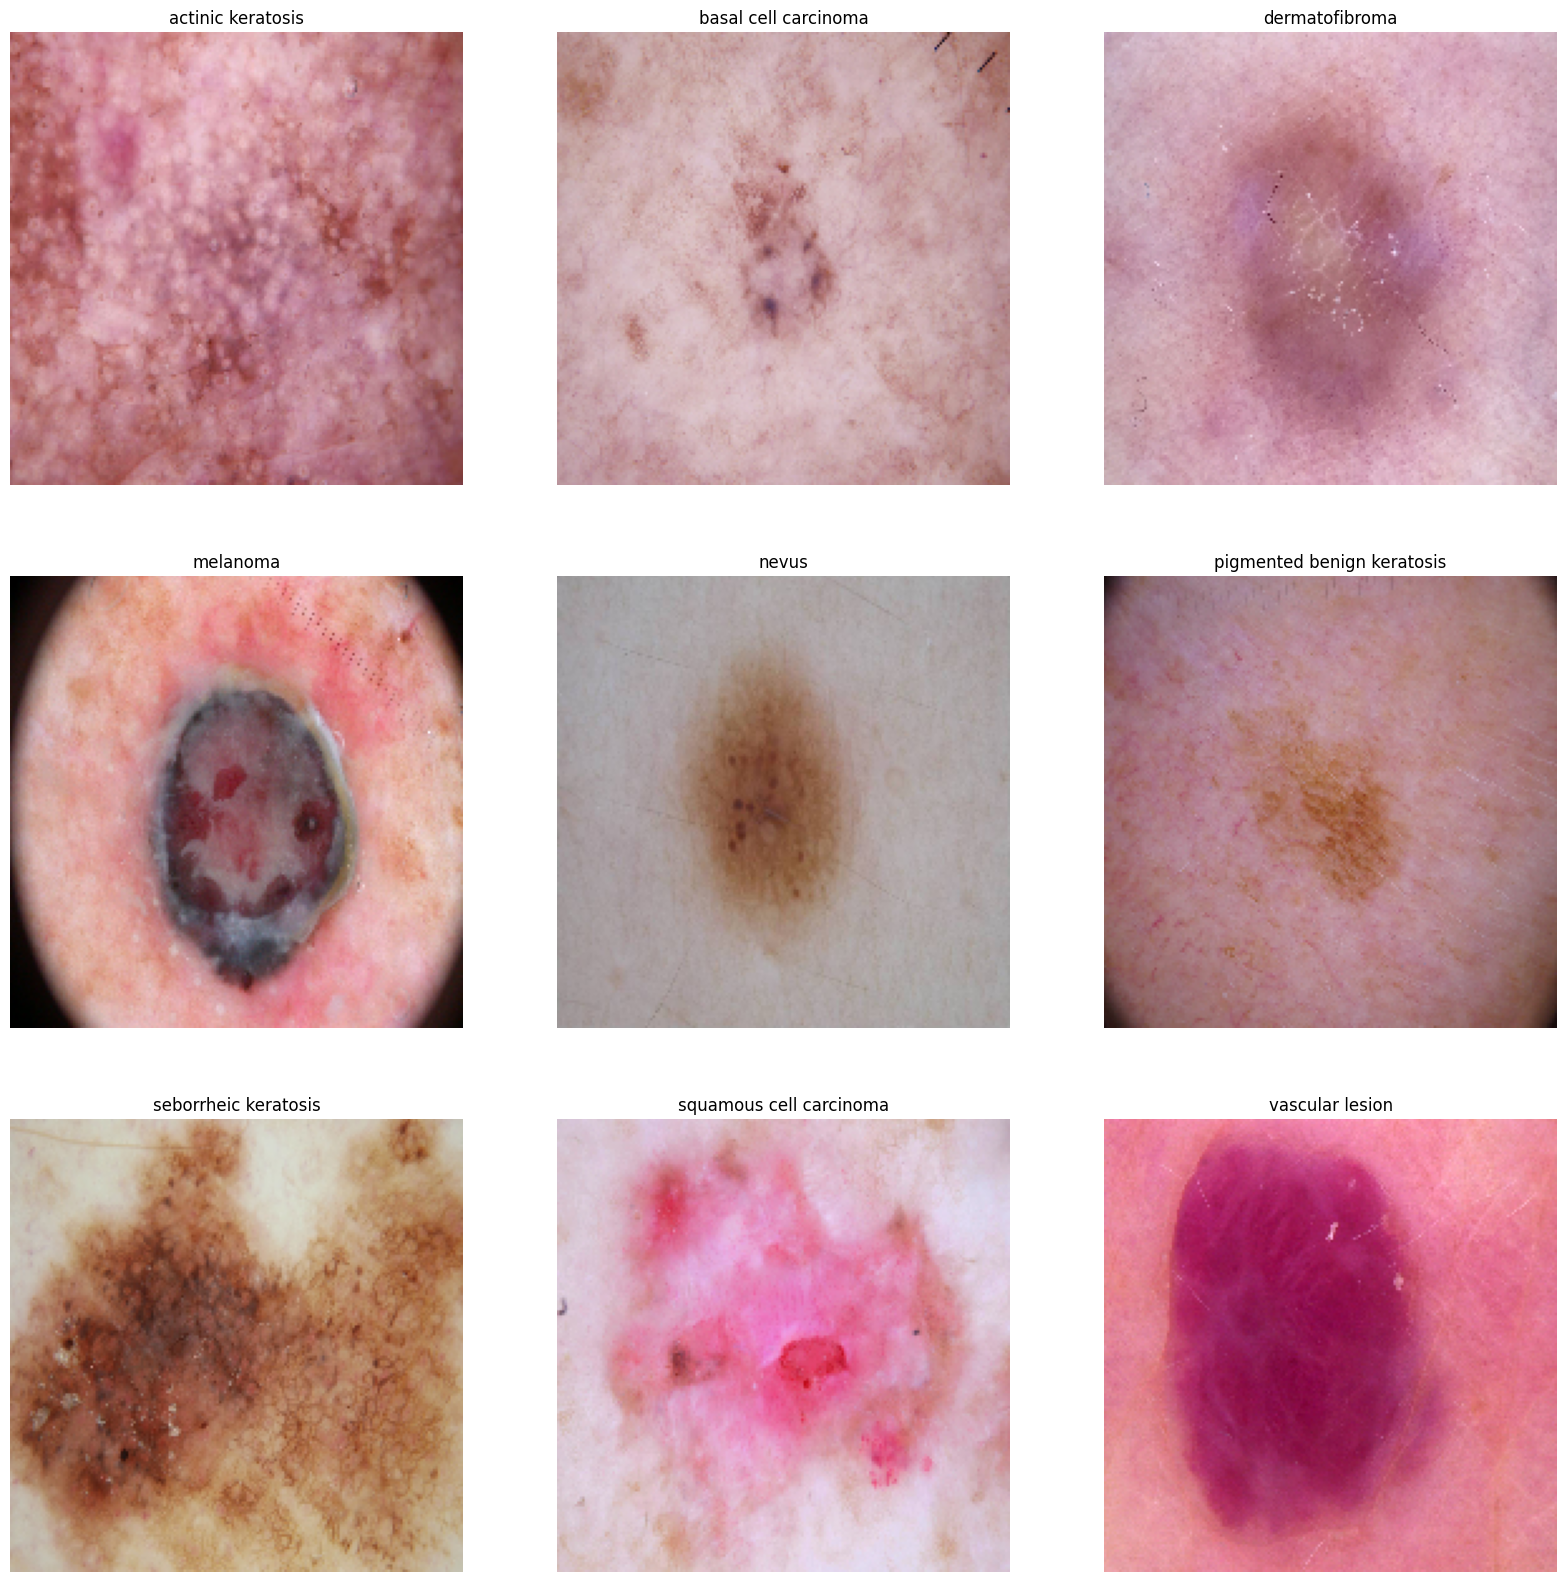

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(20,20))
index = 0
for class_name in class_names:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(str(data_dir_train)+'/'+class_name+'/'+os.listdir(str(data_dir_train)+'/'+class_name)[0], target_size=(180,180)))
    plt.title(class_name)
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
model = Sequential()

model.add(layers.Rescaling(scale=1./255, input_shape=(180,180,3)))

#Layer 1
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

#Layer 2
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

#Layer 3
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [11]:
### Compiling the model using 'Adam' as optimizer and SparseCategoricalCrossentropy as loss function.
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [13]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 134s 447ms/step - accuracy: 0.2269 - loss: 2.1058 - val_accuracy: 0.3430 - val_loss: 1.8059
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3727 - loss: 1.7549 - val_accuracy: 0.4209 - val_loss: 1.6105
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4519 - loss: 1.5047 - val_accuracy: 0.4610 - val_loss: 1.4489
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5347 - loss: 1.3704 - val_accuracy: 0.5078 - val_loss: 1.3783
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5256 - loss: 1.3054 - val_accuracy: 0.4633 - val_loss: 1.4159
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5611 - loss: 1.2207 - val_accuracy: 0.5189 - val_loss: 1.3730
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5913 - loss: 1.1494 - val_accuracy: 0.5145 - val_loss: 1.4213
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6243 - loss: 1.0112 - val_accuracy: 0.5056 

### Visualizing training results

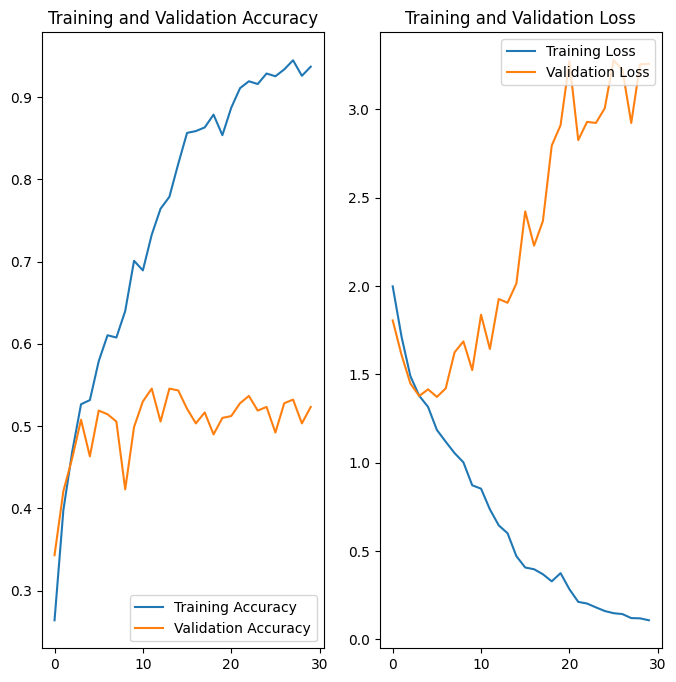

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**: The model has clearly overfit. The test accuracy is in the ballpark of 0.9 whereas the train data does not go beyond 0.5.

As a remediation, the next step would be to include Batch Normalization and Dropouts. This would help us to curb overfitting seen in the previous model

### Creating the new model as described.

In [15]:
model2 = Sequential()

model2.add(layers.Rescaling(scale=1./255, input_shape=(180,180,3)))

#Layer 1
model2.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model2.add(layers.Dropout(0.25))

#Layer 2
model2.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model2.add(layers.Dropout(0.25))

#Layer 3
model2.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))

model2.add(layers.Dense(len(class_names), activation='softmax'))

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,649,033 (25.36 MB)

 Trainable params: 6,648,585 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

### Compiling the model

In [16]:
## Your code goes here
model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [17]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.2388 - loss: 11.9940 - val_accuracy: 0.1960 - val_loss: 27.3782
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3449 - loss: 2.2970 - val_accuracy: 0.1960 - val_loss: 26.7223
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3979 - loss: 1.6789 - val_accuracy: 0.1960 - val_loss: 23.2431
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4432 - loss: 1.7261 - val_accuracy: 0.1670 - val_loss: 14.7519
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5031 - loss: 1.5559 - val_accuracy: 0.1693 - val_loss: 19.5443
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5381 - loss: 1.4010 - val_accuracy: 0.2249 - val_loss: 7.1607
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5780 - loss: 1.3676 - val_accuracy: 0.3252 - val_loss: 9.9625
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5839 - loss: 1.2840 - val_accuracy: 0.

### Visualizing the results

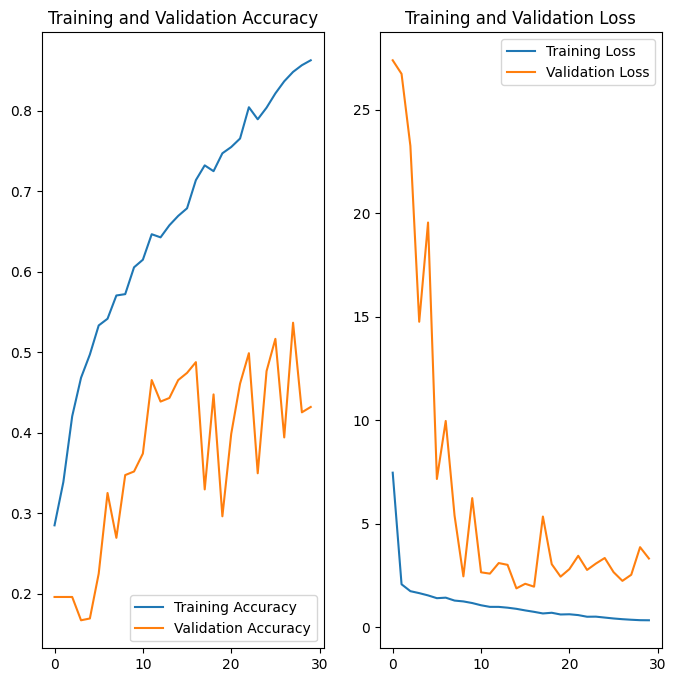

In [18]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**: Although slightly better than the previous model, we see signs of overfitting here also. But is it overfitting?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Total Number of Images = 2249
                        Class  No. of Images  Percentage
7        seborrheic keratosis             77    0.034237
6              dermatofibroma             95    0.042241
0           actinic keratosis            114    0.050689
4             vascular lesion            139    0.061805
3     squamous cell carcinoma            181    0.080480
5                       nevus            357    0.158737
1        basal cell carcinoma            376    0.167185
2                    melanoma            448    0.199200
8  pigmented benign keratosis            462    0.205425


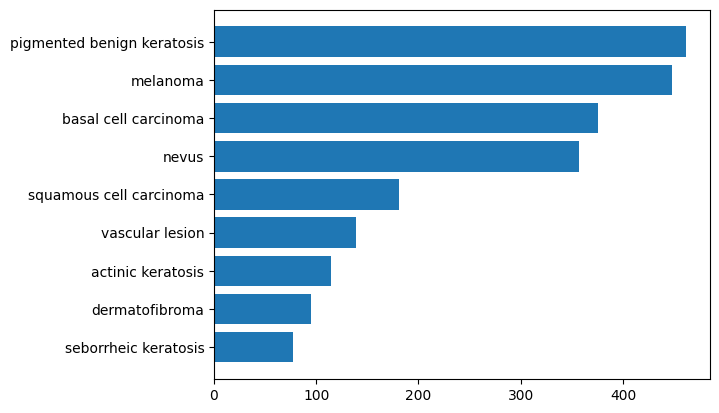

In [19]:
## Your code goes here.
#def class_distribution_count(directory):
count= []
directory = data_dir_train
for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
df = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Images'])
df.sort_values(by='No. of Images', ascending=True, inplace=True)
total_images = df['No. of Images'].sum()
print(f'Total Number of Images = {total_images}')
df['Percentage'] = df['No. of Images'] / total_images
print(df)
plt.barh(df['Class'], df['No. of Images'])
plt.show()

#### **Observations**: As we can see, there is imbalance in number of samples. This can leads to incorrect training data and can cause incorrect predictions.
#### - **seborrheic keratosis** has the least number of samples which is 77 which is only 3.4% of total data.
#### - **pigmented benign keratosis** has the most samples which is 462 which is 20 percent of total data.


#### Rectifying the class imbalance
#### **Context:** Using python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [20]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [21]:
path_to_training_dataset="/content/drive/MyDrive/CNN_Assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F827E128F70>: 100%|██████████| 500/500 [00:04<00:00, 105.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F826C7AB6D0>: 100%|██████████| 500/500 [00:05<00:00, 96.58 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F826C770FA0>: 100%|██████████| 500/500 [00:04<00:00, 112.62 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F832B094550>: 100%|██████████| 500/500 [00:13<00:00, 36.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F826C770BB0>: 100%|██████████| 500/500 [00:14<00:00, 33.86 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F82381EA290>: 100%|██████████| 500/500 [00:04<00:00, 104.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F826C7EDB70>: 100%|██████████| 500/500 [00:06<00:00, 74.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F827DD51810>: 100%|██████████| 500/500 [00:04<00:00, 105.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F82381E8E50>: 100%|██████████| 500/500 [00:04<00:00, 111.02 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [22]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [23]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [24]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

Total Number of Images = 6749
                        Class  No. of Images  Percentage
7        seborrheic keratosis            577    0.085494
6              dermatofibroma            595    0.088161
0           actinic keratosis            614    0.090976
4             vascular lesion            639    0.094681
3     squamous cell carcinoma            681    0.100904
5                       nevus            857    0.126982
1        basal cell carcinoma            876    0.129797
2                    melanoma            948    0.140465
8  pigmented benign keratosis            962    0.142540


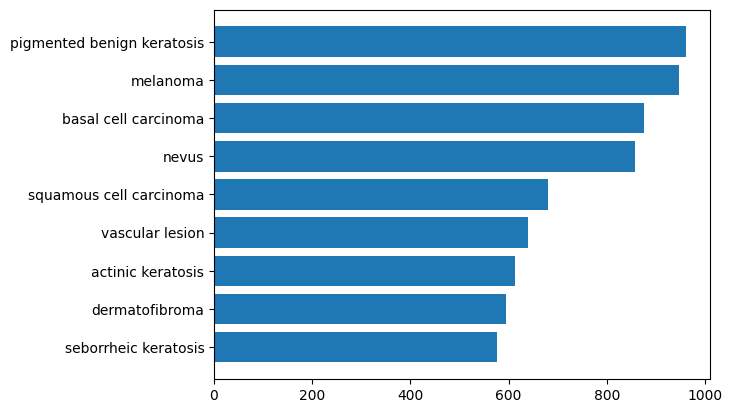

In [25]:
df['No. of Images'] = df['No. of Images'] + 500
total_images = df['No. of Images'].sum()
print(f'Total Number of Images = {total_images}')
df['Percentage'] = df['No. of Images'] / total_images
print(df)
plt.barh(df['Class'], df['No. of Images'])
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Now creating a model on the augmented data**

In [26]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### Creating model
Adding l2 regularizer to the previous model

In [29]:
from tensorflow.keras.regularizers import l2

model3 = Sequential()

model3.add(layers.Rescaling(scale=1./255, input_shape=(180,180,3)))

#Layer 1
model3.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model3.add(layers.Dropout(0.25))

#Layer 2
model3.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model3.add(layers.Dropout(0.25))

#Layer 3
model3.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.001)))
model3.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model3.add(layers.Dropout(0.5))

model3.add(layers.Flatten())

model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.25))
model3.add(layers.Dense(len(class_names), activation='softmax'))

model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model

In [30]:
model3.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [31]:
epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True,
  callbacks=[early_stopping]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.1427 - loss: 2.5088 - val_accuracy: 0.2276 - val_loss: 2.1038
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2210 - loss: 2.1135 - val_accuracy: 0.2595 - val_loss: 1.9525
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3093 - loss: 1.8645 - val_accuracy: 0.3803 - val_loss: 1.7147
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4190 - loss: 1.6177 - val_accuracy: 0.4322 - val_loss: 1.5120
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4647 - loss: 1.4723 - val_accuracy: 0.4722 - val_loss: 1.4622
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4903 - loss: 1.3740 - val_accuracy: 0.5219 - val_loss: 1.3529
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.5216 - loss: 1.3352 - val_accuracy: 0.5182 - val_loss: 1.3350
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5360 - loss: 1.2595 -

#### Visualize the model results

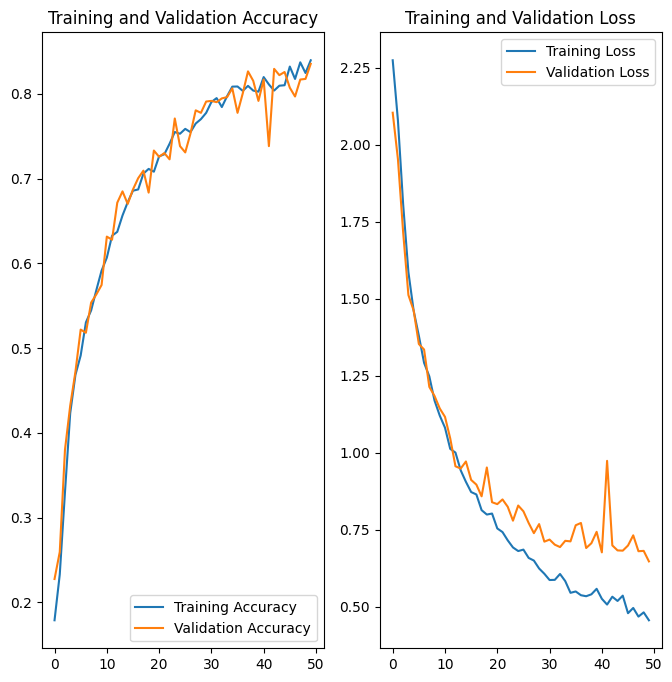

In [35]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**:
Here, can can observe that the validation accuracy is more than training accuracy. Although this cannot be considered as overfitting, because of the quality of data augmentation, the validation data might appear familiar to the model.


#### Model Evaluation and predictions on Test data

Loading Test Data

In [36]:
test_dataset = keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CNN_Assignment/Test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)



Found 118 files belonging to 9 classes.


Evaluating Model

In [37]:
test_loss, test_accuracy = model3.evaluate(test_dataset)

# Print the results
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.3677 - loss: 4.4401
Test loss: 4.282805442810059
Test accuracy: 0.39830508828163147


**Conclusion**:
1. The validation accuracy data exceeds that of training accuracy after Augmenting data. This might point to the quality of augmentation itself.
2. The same model fails to come anywhere near the training accuracy or validation accuracy when evaluating test data. This definitely points to overfitting.
3. The quality of test data probably needs to be better and we might need more data (without augmentation) so that the model is generalizable.